<a href="https://colab.research.google.com/github/rdioactiv/sentimentAnalysisPrac/blob/main/articleSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install textblob
!pip install nltk
!pip install spacy
!pip install matplotlib-venn
!pip install pyLDAvis
!pip install gensim
!pip install gradio

In [19]:
import requests, spacy, praw, nltk
from getpass import getpass
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import numpy as np
import gradio as gr
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
from PIL import Image
import os
import io
from IPython.display import display
from ipywidgets import interact, widgets

/usr/local/lib/python3.10/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)


In [3]:
api_key = getpass('Enter your NewsAPI key here: ')
client_id = getpass('Enter your Reddit Client ID: ')
client_secret = getpass('Enter your Reddit Client Secret: ')
reddit = praw.Reddit(client_id=client_id, client_secret=client_secret, user_agent='sentimentUK')
nlp = spacy.load("en_core_web_sm")


Enter your NewsAPI key here: ··········
Enter your Reddit Client ID: ··········
Enter your Reddit Client Secret: ··········


In [12]:
# Fetch data
url = f"https://newsapi.org/v2/top-headlines?country=gb&apiKey={api_key}"
response = requests.get(url)
data = response.json()
headlines = [article['title'].lower() for article in data['articles']]
posts = [post.title.lower() for post in reddit.subreddit('unitedkingdom').hot(limit=10)]

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



In [13]:
# Preprocess text
nltk.download(['punkt', 'stopwords'])
stop_words = set(stopwords.words('english'))
def preprocess(text):
    return [token.lemma_ for token in nlp(text) if (token.lemma_ not in stop_words and token.is_alpha)]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Vectorize and fit LDA (scikit-learn)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform([" ".join(preprocess(text)) for text in headlines + posts])
lda = LDA(n_components=5)
lda.fit(X)

LatentDirichletAllocation(n_components=5)

In [15]:
def get_automatic_labels(model, vectorizer, top_n=3):
    labels = []
    words = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        top_keywords = [words[i] for i in topic.argsort()[:-top_n - 1:-1]]
        label = ', '.join(top_keywords)
        labels.append(f"Topic {topic_idx+1}: {label}")
    return labels

# Get automatic labels
auto_labels = get_automatic_labels(lda, vectorizer)

# Use these labels in your visualizations


In [20]:
# Prepare data for Gensim's LDA
texts = [word_tokenize(text) for text in headlines + posts]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
ldamodel = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
# Visualization
pyLDAvis.enable_notebook()
lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# Get topic distributions for Reddit and news
reddit_topic_dists = [lda.transform(vectorizer.transform([" ".join(preprocess(post))])) for post in posts]
news_topic_dists = [lda.transform(vectorizer.transform([" ".join(preprocess(headline))])) for headline in headlines]

# Aggregate topic distributions (Here, I'm using sum; you can also use average)
reddit_agg_topics = np.sum(np.array([np.argmax(dist) for dist in reddit_topic_dists]), axis=0)
news_agg_topics = np.sum(np.array([np.argmax(dist) for dist in news_topic_dists]), axis=0)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
# Assign dominant topic to each Reddit post and news article
reddit_dominant_topics = [np.argmax(dist[0]) for dist in reddit_topic_dists]
news_dominant_topics = [np.argmax(dist[0]) for dist in news_topic_dists]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


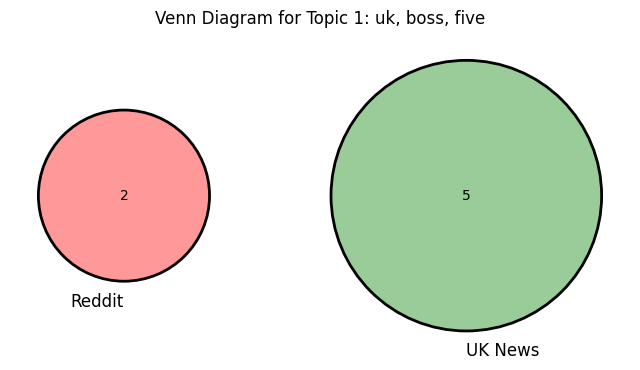

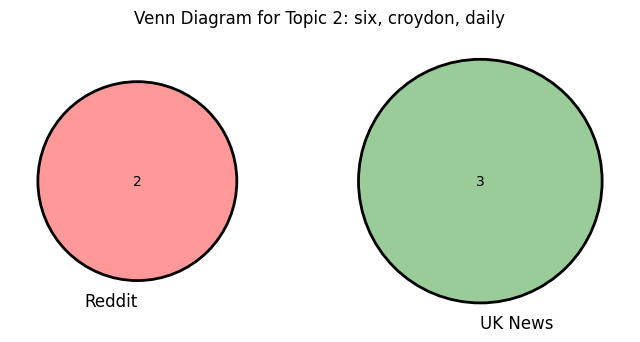

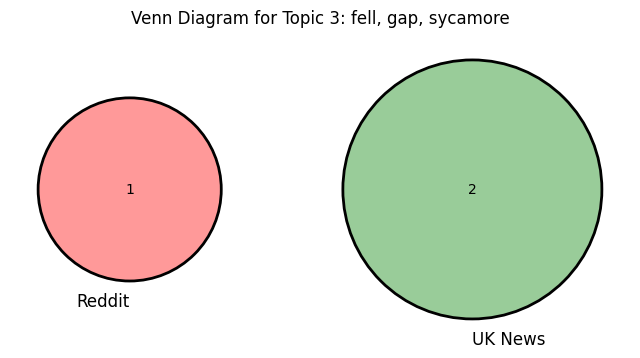

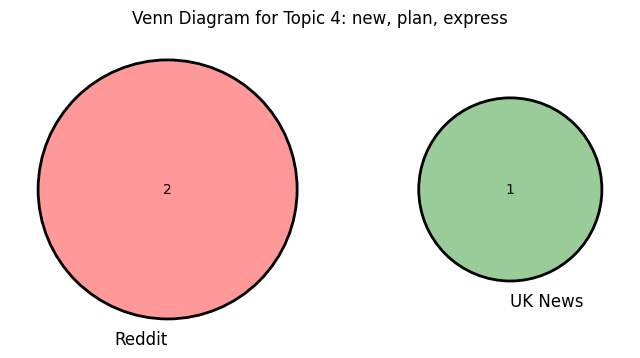

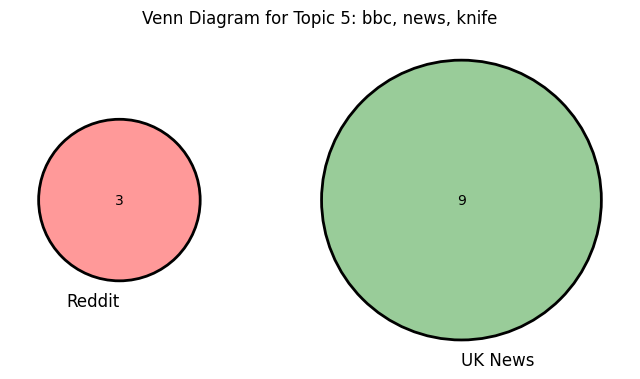

In [24]:
# For each topic, create a Venn diagram
for i in range(5):  # Assuming 5 topics
    plt.figure(figsize=(8, 8))  # Set the figure size
    topic_label = auto_labels[i]  # Use automatic labels instead of keywords

    # Count occurrences in Reddit and news
    reddit_count = reddit_dominant_topics.count(i)
    news_count = news_dominant_topics.count(i)

    # Count overlap
    overlap_count = len(set([post for idx, post in enumerate(posts) if reddit_dominant_topics[idx] == i]) &
                        set([headline for idx, headline in enumerate(headlines) if news_dominant_topics[idx] == i]))

    venn = venn2(subsets=(reddit_count, news_count, overlap_count), set_labels=('Reddit', 'UK News'))
    venn_circles = venn2_circles(subsets=(reddit_count, news_count, overlap_count))

    plt.title(f"Venn Diagram for {topic_label}")
    plt.savefig(f"venn_topic_{i}.png")  # Save the figure
    plt.show()  # Show the figure

